In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
df = pd.read_csv('eda_data.csv')

# choose relevant columns 
df.columns

Index(['Unnamed: 0', 'Job Title', 'Salary Estimate', 'Job Description',
       'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [3]:
df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_comp','hourly','employer_provided',
             'job_state','same_state','age','python_yn','spark','aws','excel','job_simp','seniority','desc_len']]

In [4]:
# get dummy data 
df_dum = pd.get_dummies(df_model)

In [5]:
#train test split 
from sklearn.model_selection import train_test_split

X = df_dum.drop('avg_salary', axis =1)
y = df_dum.avg_salary.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# multiple linear regression 
import statsmodels.api as sm

X_sm = X = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
lm.fit(X_train, y_train)

np.mean(cross_val_score(lm,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

-20.7668551289225

,alpha,error
12,0.13,-19.257798


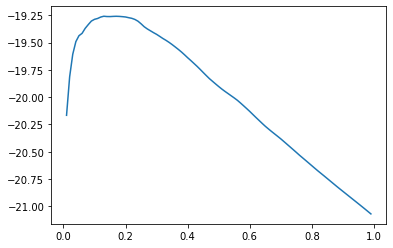

In [7]:
# lasso regression 
lm_l = Lasso(alpha=.13)
lm_l.fit(X_train,y_train)
np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))
    
plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]

In [8]:
# random forest 
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

-15.042816788870086

In [9]:
# tune models GridsearchCV 
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':range(10,300,10), 'criterion':('mse','mae'), 'max_features':('auto','sqrt','log2')}

gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',n_jobs=1,cv=3)
gs.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [10]:
gs.best_score_
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [11]:
# test ensembles 
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

In [12]:
from sklearn.metrics import mean_absolute_error

In [13]:
#linear regression
mean_absolute_error(y_test,tpred_lm)

18.85518999021529

In [14]:
#Lasso regression
mean_absolute_error(y_test,tpred_lml)

19.665303712749914

In [15]:
#Random Forest
mean_absolute_error(y_test,tpred_rf)

11.075782997762865